In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.constants import *
import pytpc.simulation
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import yaml
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [4]:
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [5]:
sim = EventSimulator(config)

In [6]:
num_evts = 100
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)


In [102]:
p = next(pgen)
print(p)

#good_p = [2.45394647e-03, 1.20503333e-03, 8.35099727e-01, 2.30922063e+00,
#       4.56309757e+00, 2.00254226e+00]

(array([0.00985403, 0.00773494, 0.36170309, 0.66628263, 0.44018685,
       1.90862981]), array([ 0.01265938,  0.009937  , -0.99987049]))


In [103]:
evtRandom, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
pyevtRandom = sim.convert_event(evtRandom)
Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)


In [104]:
Random_xy = Random_xyzs[:, 0:2]
Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
#The center of curvature of the track, in mm.
Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy), rotate_pads=True, drop_beampads=True)
Random_uvw_values = Random_uvw.values
print(Random_cu, Random_cv)

Random_mcres, Random_minChis, Random_all_params, Random_good_param_idx = mcfitter.process_event(Random_uvw, Random_cu, Random_cv, return_details=True)
print(Random_mcres)

50.207199820713164 -37.150744722563545
{'x0': -0.00024322946635304665, 'y0': 0.0006616694978794104, 'z0': 0.3627744854858681, 'enu0': 0.6939404923739109, 'azi0': 0.6331949159270623, 'pol0': 1.910480024475462, 'posChi2': 0.4080340018206779, 'enChi2': 0.10430817651624055, 'vertChi2': 0.009939341954527578, 'lin_scat_ang': 1.2132588679860579, 'lin_beam_int': 362.60063147916804, 'lin_chi2': 0.639472203750941, 'rad_curv': 56.18011123420968, 'brho': 0.10075412941302948, 'curv_en': 0.4861925790315646, 'curv_ctr_x': 50.207199820713164, 'curv_ctr_y': -37.150744722563545}


In [105]:
evtClean, ctr = sim.make_event(Random_mcres['x0'], Random_mcres['y0'], Random_mcres['z0'], Random_mcres['enu0'], Random_mcres['azi0'], Random_mcres['pol0'])
#evtClean, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

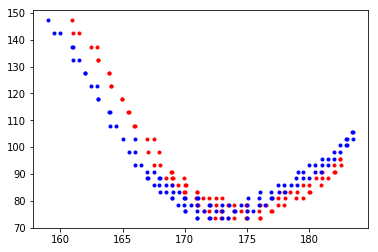

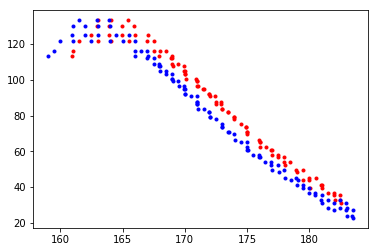

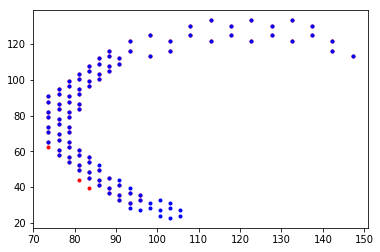

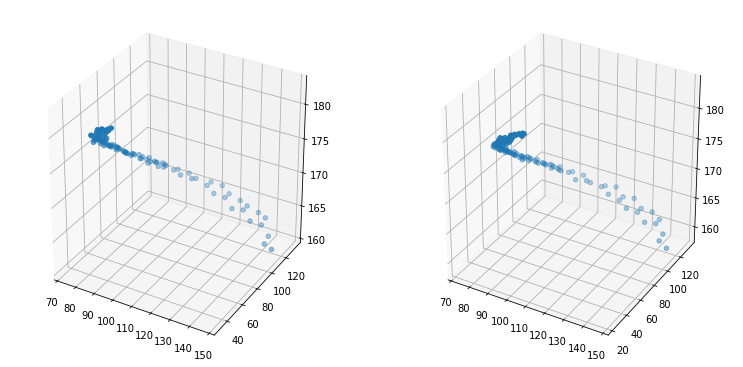

In [106]:
plt.plot(Random_xyzs[:, 2], Random_xyzs[:, 0], 'r.')
plt.plot(sim_xyzs[:, 2], sim_xyzs[:, 0], 'b.')
plt.show()
plt.plot(Random_xyzs[:, 2], Random_xyzs[:, 1], 'r.')
plt.plot(sim_xyzs[:, 2], sim_xyzs[:, 1], 'b.')
plt.show()
plt.plot(Random_xyzs[:, 0], Random_xyzs[:, 1], 'r.')
plt.plot(sim_xyzs[:, 0], sim_xyzs[:, 1], 'b.')
plt.show()



fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_xyzs[:,0],Random_xyzs[:,1],Random_xyzs[:,2])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_xyzs[:,0],sim_xyzs[:,1],sim_xyzs[:,2])